### This is an example of where Scipy default optimizer (L-BFGS-B) does not correctly estimate the inefficiency variance. Even with $\gamma$ set to 0 and small measurement error, it estimates $\eta = 0$.

#### January 22, 2021 (after SFMA meeting)
Install the latest commit of `anml` from GitHub and the `logerf` branch from `SFMA`

In [36]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sfma.api import SFMAModel

## Make Simulations

In [37]:
np.random.seed(1)

In [38]:
n = 100

In [39]:
intercept = 1.5
slope = 5

x_domain = [0, 10]

ineff = 0.4

sample_size_1 = [1000, 0.7]
sample_size_2 = [1000, 0.3]

In [40]:
def frontier(x):
    return np.log(intercept + slope * x)

In [61]:
def simulate():
    x = np.random.uniform(low=x_domain[0], high=x_domain[1], size=n)
    sample_sizes_1 = np.random.negative_binomial(
        n=sample_size_1[0], p=sample_size_1[1], size=int(n / 2)
    )
    sample_sizes_2 = np.random.negative_binomial(
        n=sample_size_2[0], p=sample_size_2[1], size=int(n / 2)
    )
    sample_sizes = np.append(sample_sizes_1, sample_sizes_2)
    
    the_frontier = frontier(x)
    inefficiency = np.random.exponential(ineff, size=n)
    means = the_frontier - inefficiency
    samples = [np.random.normal(m, scale=4, size=s) for m, s in zip(means, sample_sizes)]
    est_means = np.array([np.mean(s) for s in samples])
    est_sterr = np.array([np.sqrt(np.sum(sum((s - np.mean(s))**2)) / ((len(s) - 1)))/np.sqrt(len(s)) for s in samples])
    df = pd.DataFrame({
        'output': est_means,
        'se': est_sterr,
        'input': x,
        'ones': np.ones(len(x)),
        'frontier': the_frontier,
        'truth': means,
        'sample_size': sample_sizes
    })
    return df

In [62]:
sim = simulate()

In [63]:
the_frontier = sim['frontier']
linspace = np.linspace(x_domain[0], x_domain[1])
front = frontier(linspace)

<ErrorbarContainer object of 3 artists>

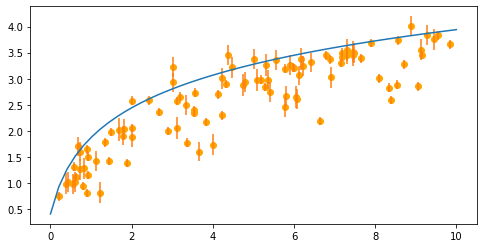

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(linspace, front, linestyle='solid')
ax.scatter(sim.input, sim.output, color='orange')
ax.errorbar(sim.input, sim.output, yerr=sim.se, linestyle='None')

In [65]:
model = SFMAModel(
    df=sim,
    col_output='output',
    col_se='se',
    col_input='input'
)
concave = SFMAModel(
    df=sim,
    col_output='output',
    col_se='se',
    col_input='input',
    r_linear=True,
    concave=True
)

In [66]:
model.fit()
concave.fit()

/Users/marlena/repos/SFMA/src/sfma/models/maximal.py:91: RuntimeWarning: divide by zero encountered in true_divide
  np.dot(self.Z.T / sigma2, self.Z) + np.diag(1.0/self.gammas_padded),
/Users/marlena/repos/SFMA/src/sfma/models/maximal.py:83: RuntimeWarning: invalid value encountered in true_divide
  self._prior_fun = lambda x: np.sum(x**2/self.gammas_padded) / 2


In [67]:
sim['base_predictions'] = model.predict()
sim['concave_predictions'] = concave.predict()
sim.sort_values('input', inplace=True)

## ALERT: BUG IS HERE

#### The last entry is $\eta$ and you can see that it's 0 for the `model` object but non-zero correct) for the `concave` object.

In [68]:
model.solver.solvers[0].x_opt

array([0.64635245, 1.9827222 , 2.25746084, 3.61235569, 2.91106497,
       3.76080578, 0.        ])

In [69]:
concave.solver.solvers[0].x_opt

array([1.10277094, 2.43351323, 3.2385709 , 3.4909635 , 3.63340503,
       0.69099723])

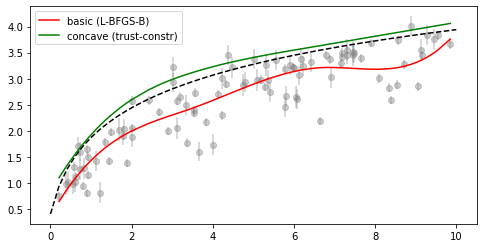

In [73]:
fig, axes = plt.subplots(1, 1, figsize=(8, 4))
axes.plot(linspace, front, linestyle='dashed', color='black')
axes.scatter(sim.input, sim.output, color='grey', alpha=0.4)
axes.errorbar(sim.input, sim.output, yerr=sim.se, linestyle='None', color='grey', alpha=0.4)
axes.plot(sim.input, sim.base_predictions, color='red', label='basic (L-BFGS-B)')
axes.plot(sim.input, sim.concave_predictions, color='green', label='concave (trust-constr)')
axes.legend()